In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from hrvanalysis import get_time_domain_features, get_frequency_domain_features, get_geometrical_features, get_csi_cvi_features, get_poincare_plot_features, get_sampen
from hrvanalysis.preprocessing import get_nn_intervals
import neurokit2 as nk

sys.path.append('..')
from util import standardize_signal, normalize_signal, load_base_data

import warnings
warnings.simplefilter("ignore")

plt.rcParams['figure.figsize'] = [20, 5]

In [2]:
DATA_PATH = "../data"
SAMPLING_RATE = 300

In [3]:
X_train, y_train, X_test = load_base_data(data_path=DATA_PATH, just_train=False, flip=True, normal=False)

# Sandbox

0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with kamath rule.
[238 242 245 242 237 246 250 240 239 245 239 237 240 240 232 234 236 234
 233 239 240 232 236 250 250 242 249 258 250 246 256 250 248 255 248 245
 252 244 246 252 244 245 249 244 242 245 249 241 241 242 242 247 242 240
 243 245 240 233 248 244 240 252 250 248 252 255]
[238, 242, 245, 242, 237, 246, 250, 240, 239, 245, 239, 237, 240, 240, 232, 234, 236, 234, 233, 239, 240, 232, 236, 250, 250, 242, 249, 258, 250, 246, 256, 250, 248, 255, 248, 245, 252, 244, 246, 252, 244, 245, 249, 244, 242, 245, 249, 241, 241, 242, 242, 247, 242, 240, 243, 245, 240, 233, 248, 244, 240, 252, 250, 248, 252, 255]


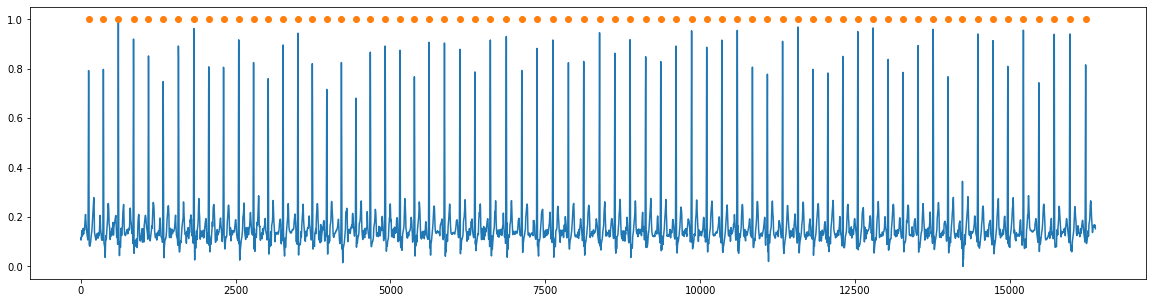

In [19]:
#i = 2651
i = 2352

signal = X_test.loc[i].dropna().to_numpy(dtype='float32')
signal = normalize_signal(signal)

signals, info = nk.ecg_process(signal, sampling_rate=SAMPLING_RATE)
r_peaks = info["ECG_R_Peaks"]
rr_intervals = r_peaks[1:]-r_peaks[:-1]

plt.figure()
#plt.plot(signal[3000:5000])
plt.plot(signal)
plt.plot(r_peaks, np.ones(len(r_peaks)), 'o')
nn_intervals = get_nn_intervals(rr_intervals, low_rri=30)
print(rr_intervals)
print(nn_intervals)


In [ ]:
for i in tqdm(len(X_train)):
    signal = X_train.loc[i].dropna().to_numpy(dtype='float32')
    signal = normalize_signal(signal)

    signals, info = nk.ecg_process(signal, sampling_rate=SAMPLING_RATE)
    r_peaks = info["ECG_R_Peaks"]
    rr_intervals = r_peaks[1:]-r_peaks[:-1]

# Feature extraction

In [37]:
def process_signal(signal):
    try:
        signals, info = nk.ecg_process(signal, sampling_rate=SAMPLING_RATE)
    except:
        print("ERROR. Couldn't process ecg with neurokit")
        signal = 1-signal
        signals, info = nk.ecg_process(signal, sampling_rate=SAMPLING_RATE)
        
    r_peaks = info["ECG_R_Peaks"]

    rr_intervals = r_peaks[1:]-r_peaks[:-1]
    nn_intervals = get_nn_intervals(rr_intervals, low_rri=30, verbose=False)

    rr_features = {}
    nn_features = {}

    try:
        rr_features.update(get_time_domain_features(rr_intervals))
        nn_features.update(get_time_domain_features(nn_intervals))

        rr_features.update(get_geometrical_features(rr_intervals))
        nn_features.update(get_geometrical_features(nn_intervals))

        rr_features.update(get_frequency_domain_features(rr_intervals, sampling_frequency=SAMPLING_RATE))
        nn_features.update(get_frequency_domain_features(nn_intervals, sampling_frequency=SAMPLING_RATE))

        rr_features.update(get_csi_cvi_features(rr_intervals))
        nn_features.update(get_csi_cvi_features(nn_intervals))

        rr_features.update(get_poincare_plot_features(rr_intervals))
        nn_features.update(get_poincare_plot_features(nn_intervals))

        rr_features.update(get_sampen(rr_intervals))
        nn_features.update(get_sampen(nn_intervals))
    except:
        print("ERROR. Couldn't extract features.")
        rr_features = {}
        nn_features = {}
    
    return rr_features, nn_features

In [61]:
def process_dataframe(df):
    rr_feature_vectors = []
    nn_feature_vectors = []
    feature_names = None
    for i in tqdm(range(len(df))):
        signal = df.loc[i].dropna().to_numpy(dtype='float32')
        signal = normalize_signal(signal)

        rr_features, nn_features = process_signal(signal)
        assert(rr_features.keys() == nn_features.keys())
        
        if feature_names is None and len(rr_features)!=0:
            feature_names = rr_features.keys()

        if len(rr_features) == 0:
            for fn in feature_names:
                rr_features[fn] = None
                nn_features[fn] = None

        rr_feature_vectors.append(list(rr_features.values()))
        nn_feature_vectors.append(list(nn_features.values()))

    return feature_names, np.array(rr_feature_vectors), np.array(nn_feature_vectors)

### Train data

In [7]:
fn, rr_fv, nn_fv = process_dataframe(X_train)

100%|██████████| 5117/5117 [20:31<00:00,  4.16it/s]


In [8]:
X_train_rr_hrv = pd.DataFrame(rr_fv, columns = fn)
X_train_rr_hrv.to_csv(f'{DATA_PATH}/hrv/rr/X_train.csv', index_label='id')

X_train_nn_hrv = pd.DataFrame(nn_fv, columns = fn)
X_train_nn_hrv.to_csv(f'{DATA_PATH}/hrv/nn/X_train.csv', index_label='id')

### Test data

In [62]:
fn_test, rr_fv_test, nn_fv_test = process_dataframe(X_test)

 68%|██████▊   | 2326/3411 [09:15<04:14,  4.27it/s]

ERROR. Couldn't process ecg with neurokit


 78%|███████▊  | 2652/3411 [10:34<02:40,  4.72it/s]

ERROR. Couldn't extract features.


100%|██████████| 3411/3411 [13:29<00:00,  4.21it/s]


In [60]:
assert fn_test == fn
X_test_rr_hrv = pd.DataFrame(rr_fv_test, columns = fn_test)
X_test_rr_hrv.to_csv(f'{DATA_PATH}/hrv/rr/X_test.csv', index_label='id')

X_test_nn_hrv = pd.DataFrame(nn_fv_test, columns = fn_test)
X_test_nn_hrv.to_csv(f'{DATA_PATH}/hrv/nn/X_test.csv', index_label='id')